### Test the trained AutoEncoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime

from matplotlib import pyplot as plt

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training
from utils import set_seed, get_dataloader

set_seed(2021)

: 

In [5]:
resume_ckpt = Path('/scratch/gb2572/DL_project_2023/output/test_vptr/models/partial/epoch_3.tar') #specify your trained autoencoder checkpoint file
num_past_frames = 11
num_future_frames = 11
encH, encW, encC = 6, 6, 528
img_channels = 3 #Set to be 3 for BAIR dataset
N = 2
device = torch.device('cpu')
loss_name_list = ['AE_L1', 'Dtotal', 'Dfake', 'Dreal', 'AEgan']

In [8]:
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3).to(device)
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Tanh').to(device)

init_weights(VPTR_Enc)
init_weights(VPTR_Dec)

loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, 
                                         {}, resume_ckpt, loss_name_list)

initialize network with normal
initialize network with normal


In [12]:
_, _, test_loader, renorm_transform = get_dataloader('BAIR', N, Path('/train'), Path('/val'), test_past_frames = 11, test_future_frames = 11, ngpus = 1, num_workers = 1)

In [13]:
model = nn.Sequential(VPTR_Enc, VPTR_Dec)

In [14]:
sample = next(iter(test_loader))
past_frames, future_frames = sample
past_frames = past_frames.to(device)
future_frames = future_frames.to(device)
x = torch.cat([past_frames, future_frames], dim = 1 )
pred = model(x)

In [66]:
def plot_model_result(pred, row_number, col_number, n = 2):
    fig, ax = plt.subplots(row_number, col_number, figsize = (30, 5))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    #for i in range(row_number):
    for j in range(col_number):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img)
    #fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')

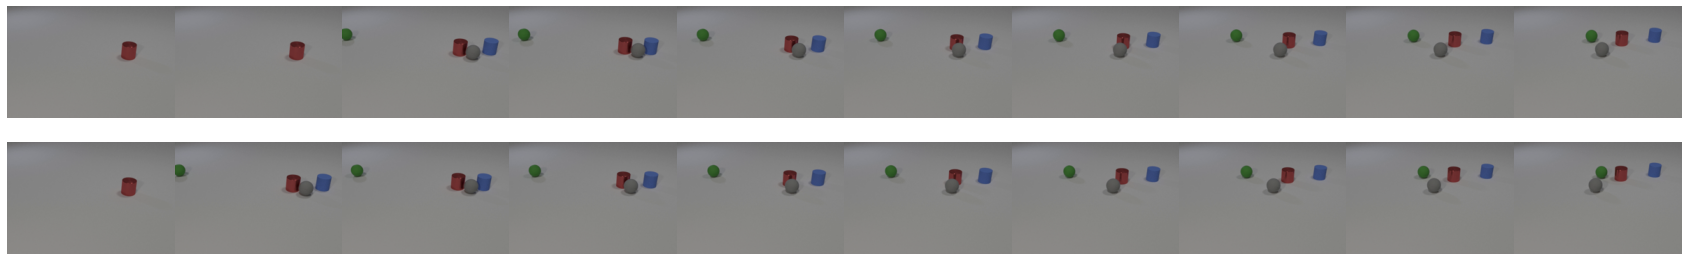

In [63]:
plot_model_result(x, 2, 10, n = 1)

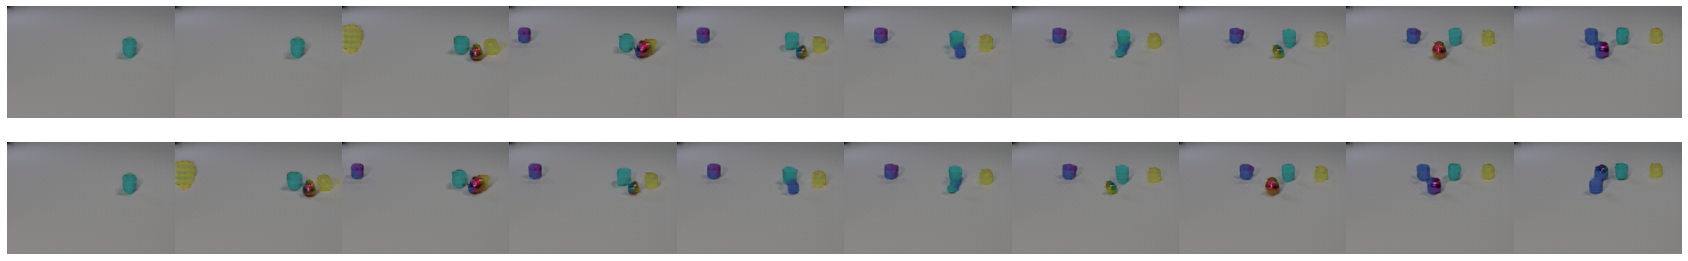

In [64]:
plot_model_result(pred, 2, 10, n = 1)

In [68]:
pred_future = model(past_frames)

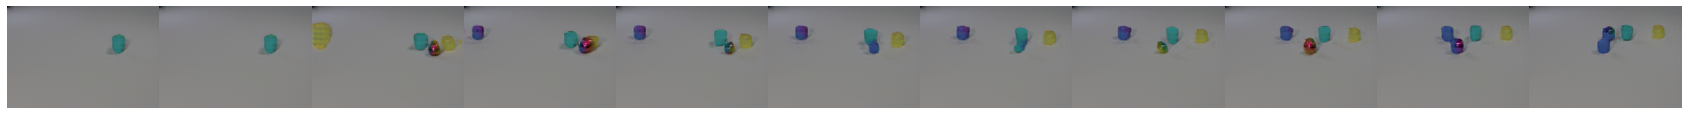

In [69]:
plot_model_result(pred_future, 1, 11, n = 1)

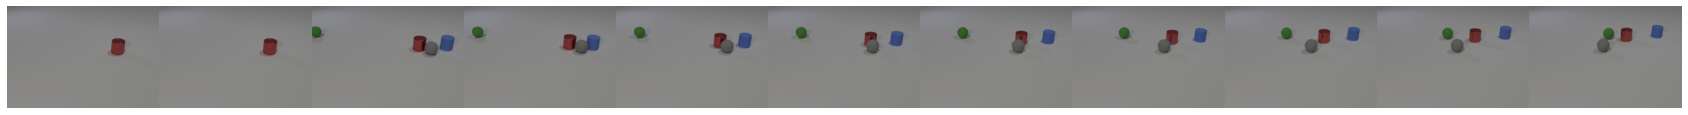

In [71]:
plot_model_result(past_frames, 1, 11, n=1)

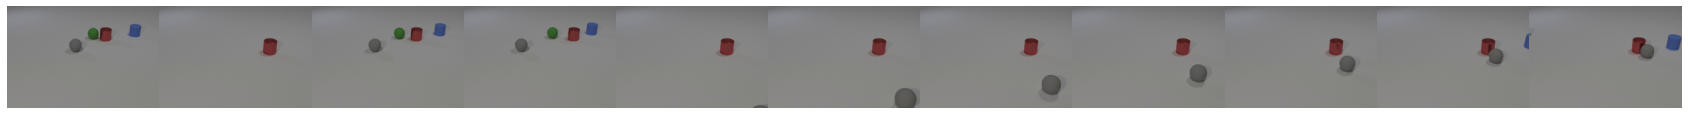

In [70]:
plot_model_result(future_frames, 1, 11, n = 1)

In [73]:
t = VPTR_Enc(past_frames)

In [74]:
t.shape

torch.Size([2, 11, 528, 20, 30])

In [76]:
import os
import torch
import torch.nn as nn
from einops import rearrange
# import imageio.v3 as iio
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings

In [89]:
from models import IJEPA_base, CustomDataParallel, EarlyStop

In [90]:
encoder = IJEPA_base(img_size=128, patch_size=16, in_chans=3, norm_layer=nn.LayerNorm, num_frames=22, attention_type='joint_space_time', dropout=0.1, mode="test", r=0.5, embed_dim=768, device=device, skip_patch=True,
                        # encoder parameters
                        enc_depth=4,
                        enc_num_heads=6,
                        enc_mlp_ratio=4.,
                        enc_qkv_bias=False,
                        enc_qk_scale=None,
                        enc_drop_rate=0.,
                        enc_attn_drop_rate=0.,
                        enc_drop_path_rate=0.1,
                        # predictor parameters
                        pred_depth=4,
                        pred_num_heads=6,
                        pred_mlp_ratio=4.,
                        pred_qkv_bias=False,
                        pred_qk_scale=None,
                        pred_drop_rate=0.1,
                        pred_attn_drop_rate=0.1,
                        pred_drop_path_rate=0.1,
                        # positional and spacial embedding parameters
                        pos_drop_rate=0.1,
                        time_drop_rate=0.1)

TypeError: __init__() got an unexpected keyword argument 'skip_patch'

In [84]:
path_partials = os.path.join("/scratch/gb2572/DL_project_2023/output/test_5", "models/partial")
if os.path.exists(path_partials):
    checkpoint = torch.load(os.path.join(path_partials, "checkpoint.pkl"), map_location=device)
    encoder_state_dict = checkpoint['model_state_dict']
    encoder.load_state_dict(encoder_state_dict)
    encoder.to(device)

In [86]:
t.shape

torch.Size([2, 11, 528, 20, 30])

In [ ]:
t.transpose()

: 